### importing important modules and packages

In [ ]:
import argparse
import os
import time
from tqdm import tqdm

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchsummary import summary

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Partie 1 : Architecture VGG16

In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

--2023-11-28 09:22:02--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl [following]
--2023-11-28 09:22:03--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35454 (35K) [text/plain]
Saving to: ‘imagenet_classes.pkl’

imagenet_classes.pk 100%[===================>]  34.62K  --.-KB/s    in 0.006s  

2023-11-28 09:22:03 (5.41 MB/s) - ‘imagenet_classes.pkl’ saved [35454

In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=True)
imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb')) # chargement des classes

#imagenet_classes

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 78.2MB/s]


### Question 1 - Number of parameters
Knowing that the fully-connected layers account for the majority of the parameters in a model, give an estimate on the number of parameters of VGG16 (using the sizes given in Figure 1) <br>
**Answer:** The number of parameters for this neural network will be dominated by the #parameters of the fully connected head. We will therefore say $N^{NN}_{total} = N_{CNN} + N_{FC} \approx N_{FC}$ <br>
There are three fully connected layers with input $\Rightarrow$ output sizes $25088 \to 4096 \to 4096 \to 1000$
$N_{FC} = (25088*4096) + (4096*4096) + (4096*1000) \approx  124 \text{ Mio}$

In [ ]:
# get number of parameters in pytorch (count trainable parameters)
trainable_params = sum(
	p.numel() for p in vgg16.parameters() if p.requires_grad)
print(trainable_params/1e6) # 138 Million

138.357544


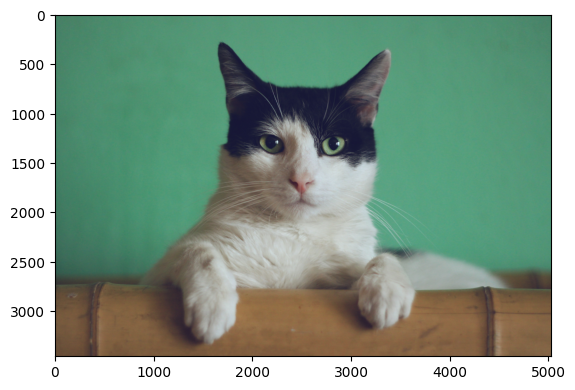

In [ ]:
cat = Image.open('cat.jpg')
#dog = Image.open('dog.jpg')

plt.imshow(cat)
#plt.imshow(dog)

# Ajoutez vos images
# VOTRE CODE ICI pour le bonus:
# TO DO

img = Image.open("cat.jpg")
img = img.resize((224, 224), Image.BILINEAR)
img = np.array(img, dtype=np.float32) / 255
img = img.transpose((2, 0, 1))

img = np.expand_dims(img, 0)
x = torch.Tensor(img)

In [ ]:
vgg16.eval()
y = vgg16(x)
y = y.detach().numpy() # transformation en array numpy
print(y.shape)

(1, 1000)


**Vizualizing activation maps**

In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
layers = np.array([module for module in vgg16.modules() if not isinstance(module, nn.Sequential)])
layers

array([VGG(
         (features): Sequential(
           (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
           (1): ReLU(inplace=True)
           (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
           (3): ReLU(inplace=True)
           (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
           (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
           (6): ReLU(inplace=True)
           (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
           (8): ReLU(inplace=True)
           (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
           (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
           (11): ReLU(inplace=True)
           (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
           (13): ReLU(inplace=True)
           (14): Conv2d(256, 256, kernel_size=(3, 3), stride=

In [ ]:
# get first activation map
layer1 = layers[1]
layer1

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
# apply to sample image

y_layer1 = nn.ReLU()(layer1(x)).squeeze(0).detach().numpy()
print(y_layer1.shape) #print(y_layer1.size()) for pytorch tensor

(64, 224, 224)


Text(0.5, 0.98, 'Activation maps after first convolutional layer (first 6 out of 64)')

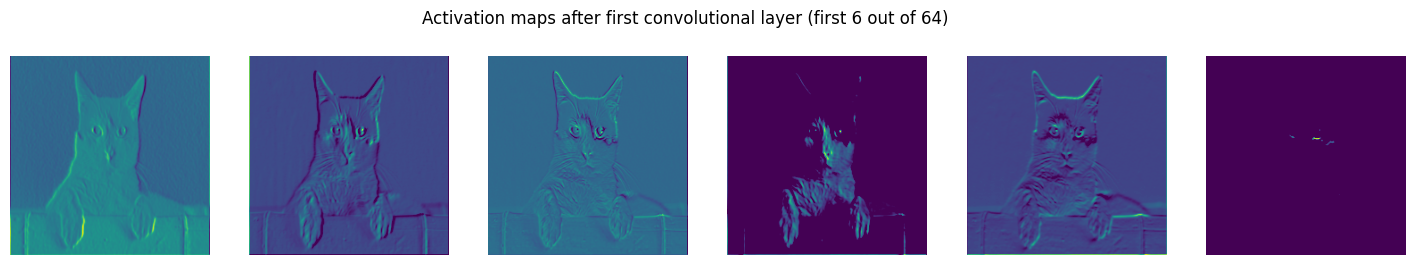

In [ ]:
N = 6
fig, axs = plt.subplots(1, N, figsize=(18, 3), sharey=True)

for i in range(N):
  axs[i].imshow(y_layer1[i])
  axs[i].axis("off")

fig.suptitle('Activation maps after first convolutional layer (first 6 out of 64)')

### Question 2 - Output size last layer
What is the output size of the last layer of VGG16? What does it correspond to? <br>
**Answer:** The output size in this classification task after the last layer of the VGG is of size [1, #classes]. This gives us the class scores after the softmax function. Those are the probabilities per class and add up to one.

### Question 3 (Bonus) - Apply the network on several images of your choice and comment on the results

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/RDFIA/Submission_2/

file_name = 'Paris_V_place_de_la_Sorbonne.jpg'
#!pwd
!ls

/content/drive/My Drive/Colab Notebooks/RDFIA/Submission_2
 15SceneData				  'Kopie von 2-c: Domain Adaptation'
 15ScenesData.zip			  'Kopie von 2-d_GANs'
'2-a: Transfer Learning Luisa'		   Paris_V_place_de_la_Sorbonne.jpg
'2-b: Visualizing Neural Networks Luisa'   rdfia_2-a.pdf
 cat.jpg				   rdfia_2-b.pdf
 dog.jpg				   rdfia_2-c.pdf
 imagenet_classes.pkl			   rdfia_2-de.pdf
 imagenet_classes.pkl.1


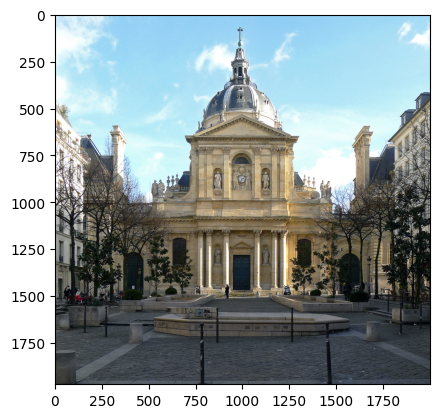

In [ ]:
img_sorbonne = Image.open(file_name)
plt.imshow(img_sorbonne)

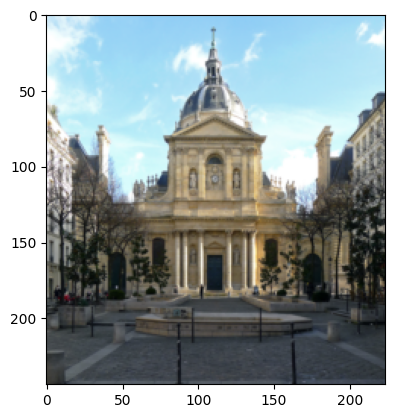

In [ ]:
img_sorbonne = img_sorbonne.resize((224,244), Image.BILINEAR)
sorbonne_resized = np.array(img_sorbonne, dtype=np.float32) / 255

plt.imshow(sorbonne_resized)

In [ ]:
sorbonne_resized = np.expand_dims(sorbonne_resized.transpose((2,0,1)), 0)
x_sorbonne = torch.Tensor(sorbonne_resized)
x_sorbonne.requires_grad = False

In [ ]:
sorbonne_layer1 = nn.ReLU()(layer1(x_sorbonne)).squeeze(0).detach().numpy()
print(sorbonne_layer1.shape) #print(y_layer1.size()) for pytorch tensor

(64, 244, 224)


In [ ]:
# apply vgg16 on sorbonne image (zero shot)

y_sorbonne = vgg16(x_sorbonne)
print('class id', torch.argmax(y_sorbonne))
print('class "palace"') # lookup table here: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
print('probability of max class', torch.max(torch.nn.functional.softmax(y_sorbonne, dim = 1)))

class id tensor(698)
class "palace"
probability of max class tensor(0.5005, grad_fn=<MaxBackward1>)


'It's a palace' :)

### Question 4 (Bonus) - Visualize several activation maps obtained after the first convolutional layer. How can we interpret them?

Text(0.5, 0.98, 'Activation maps after first convolutional layer (64 filter maps on 8x8 grid)')

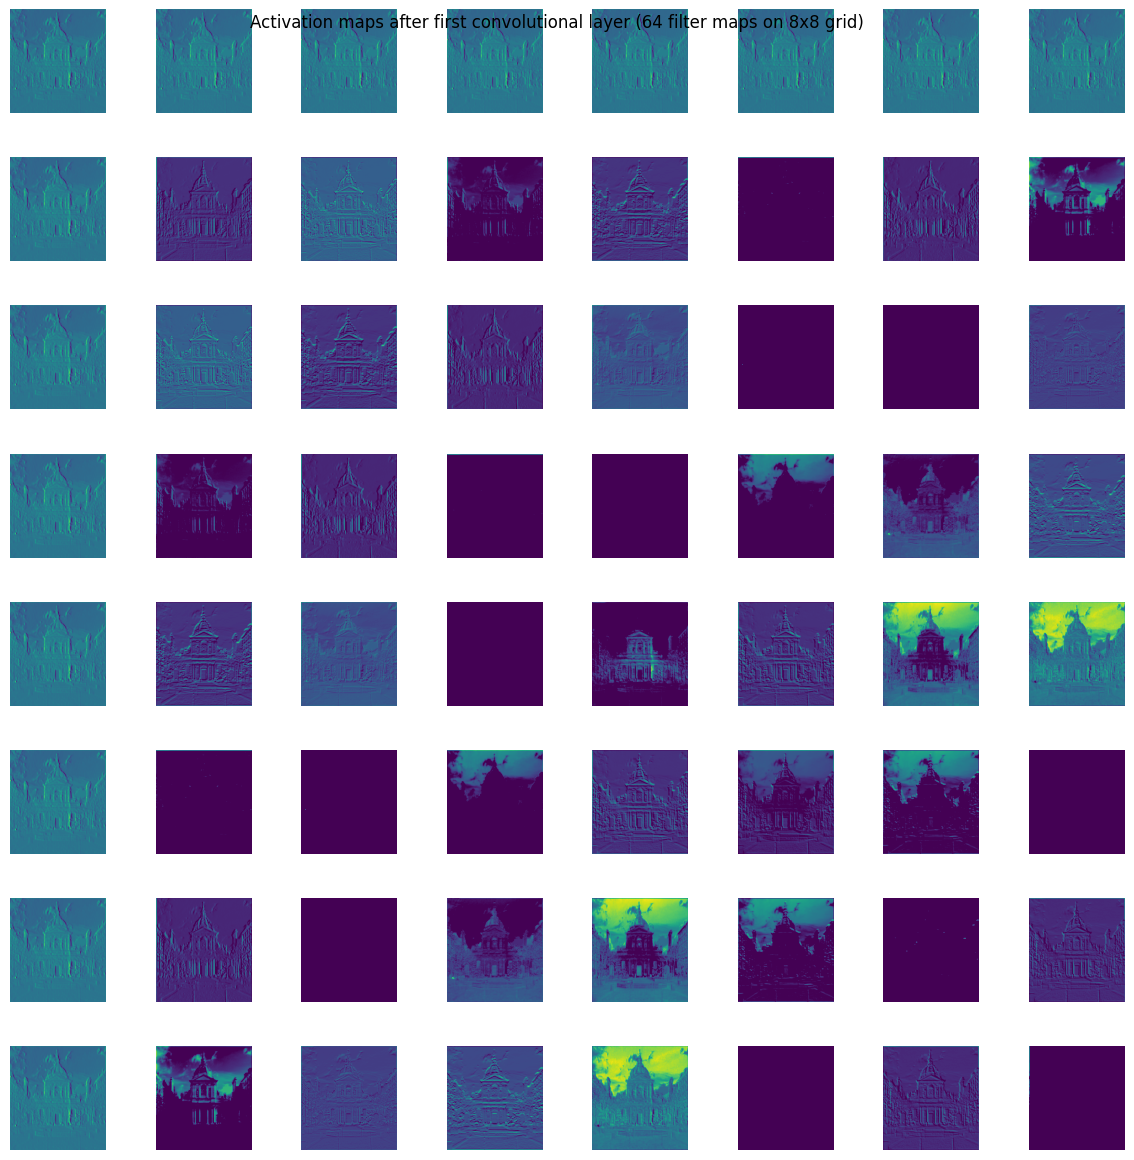

In [ ]:
N = 8
fig, axs = plt.subplots(N, N, figsize=(12, 12), sharey=True)

fig.tight_layout()

for i in range(N):
  for j in range(N):
    axs[i][j].imshow(sorbonne_layer1[i*j])
    axs[i][j].axis("off")

fig.suptitle('Activation maps after first convolutional layer (64 filter maps on 8x8 grid)')
#plt.subplots_adjust(hspace = 0.2, wspace = 0.1, top = 0.1)

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

## 2.1 Approach



In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
#!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip

#!unzip 15ScenesData.zip

In [ ]:
ls 15SceneData/test/bedroom/

image_0003.jpg  image_0035.jpg  image_0068.jpg  image_0103.jpg  image_0141.jpg  image_0182.jpg
image_0004.jpg  image_0037.jpg  image_0069.jpg  image_0104.jpg  image_0142.jpg  image_0189.jpg
image_0006.jpg  image_0039.jpg  image_0071.jpg  image_0112.jpg  image_0144.jpg  image_0190.jpg
image_0007.jpg  image_0040.jpg  image_0073.jpg  image_0113.jpg  image_0148.jpg  image_0191.jpg
image_0008.jpg  image_0042.jpg  image_0074.jpg  image_0114.jpg  image_0150.jpg  image_0192.jpg
image_0011.jpg  image_0043.jpg  image_0077.jpg  image_0115.jpg  image_0152.jpg  image_0195.jpg
image_0013.jpg  image_0047.jpg  image_0080.jpg  image_0117.jpg  image_0153.jpg  image_0196.jpg
image_0014.jpg  image_0049.jpg  image_0081.jpg  image_0118.jpg  image_0156.jpg  image_0200.jpg
image_0016.jpg  image_0050.jpg  image_0082.jpg  image_0119.jpg  image_0157.jpg  image_0202.jpg
image_0017.jpg  image_0052.jpg  image_0084.jpg  image_0120.jpg  image_0158.jpg  image_0203.jpg
image_0018.jpg  image_0053.jpg  image_0086.jpg  im

(276, 200)


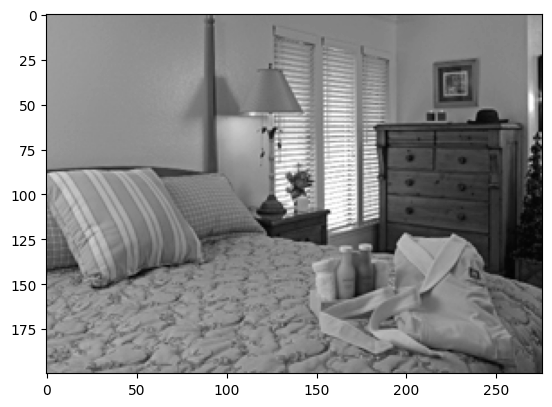

In [ ]:
scene15_img = Image.open('15SceneData/test/bedroom/image_0003.jpg')
print(scene15_img.size) # --> 1 channel image

plt.imshow(scene15_img, cmap = 'gray')

In [ ]:
class VGG16relu7(nn.Module):
  def __init__(self):
      super(VGG16relu7, self).__init__()

      # Copy the entire convolutional part
      vgg16 = torchvision.models.vgg16(pretrained=True)
      self.features = nn.Sequential(*list(vgg16.features.children()))

      # Keep a piece of the classifier: -2 to stop at relu7
      self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])

  def forward(self, x):
      x = self.features(x)
      x = x.view(x.size(0), -1)
      x = self.classifier(x)
      return x

### Question 5 - Why not directly train VGG16 on 15 Scene?
**Answer:** We could opt for a pretrained version - in this case VGG16 - for example because of limited computational resources. In general traning a deep neural network with many millions or more paramters can require a very large number of CPU hours/processing power/memory/time or access to specialized hardware, which is very costly

### Question 6 - How can pre-training on ImageNet help classification for 15 Scene?
**Answer:** VGG16 was trained on ImageNet, a dataset whose images have on average a certain mean and std. The images from 15 Scence were not drawn from the same data distribution $p_{data}(x)$ as ImageNet images.
By pretraining on ImageNet, we assume that certain image properties are shared accross the two datasets. It might be more useful to use pretrained weights instead of a random initialization.

In [ ]:
PRINT_INTERVAL = 50
CUDA = True

def get_dataset(batch_size, path):

    # Cette fonction permet de recopier 3 fois une image qui
    # ne serait que sur 1 channel (donc image niveau de gris)
    # pour la "transformer" en image RGB. Utilisez la avec
    # transform.Lambda

    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)

        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img

    #####################
    ## Votre code ici  ##
    ######################

    # Ajouter le pré-traitement
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([# Pré-traitement à faire
            transforms.Lambda(lambda x: duplicateChannel(x)), # apply duplicateChannel function from above)
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True),
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]), # standardization/normlization

        ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([ # Pré-traitement à faire
            transforms.Lambda(lambda x: duplicateChannel(x)),
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True),
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]), # standardization/normlization
        ]))

    ####################
    ##      FIN        #
    ####################

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [ ]:
my_train_loader, my_val_loader = get_dataset(batch_size = 1, path="15SceneData")

#for test_images, test_labels in my_train_loader:
#    sample_image = test_images[0].permute(1,2,0).detach().numpy() # batches of size 1
#    sample_label = test_labels[0]
#    break

In [ ]:
my_VGG16 = VGG16relu7()

print(my_VGG16.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
sample_image, _ = next(iter(my_train_loader))
print('test image shape:', sample_image.shape)

my_VGG16(sample_image)

test image shape: torch.Size([1, 3, 224, 224])


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0421, 0.0000]],
       grad_fn=<ReluBackward0>)

In [ ]:
"""for channel in [0, 1, 2]:
  print(sample_image.max())
  print(sample_image.min())

sm = plt.cm.ScalarMappable(cmap='gray')
sm.set_clim(vmin=0, vmax=1)

plt.imshow(sample_image[0].permute(1, 2, 0), vmin=0, vmax=1, interpolation = 'none')
plt.colorbar(sm)"""

"for channel in [0, 1, 2]:\n  print(sample_image.max())\n  print(sample_image.min())\n\nsm = plt.cm.ScalarMappable(cmap='gray')\nsm.set_clim(vmin=0, vmax=1)\n\nplt.imshow(sample_image[0].permute(1, 2, 0), vmin=0, vmax=1, interpolation = 'none')\nplt.colorbar(sm)"

### Question 7 - What limits can you see with feature extraction?
**Answer:** The features derived from the neural network are not by default interpretable and they might be tuned too much to a specific task.
Also, in the case where the model architecture is not well-suited to our task, they features might be lacking.

## 2.2 Feature Extraction with VGG16

### Question 8 - What is the impact of the layer at which the features are extracted?
**Answer:** Becuase we are working with a CCN, each feature that we extract at a certain network depth can only be a function of the inputs in the visual field of the respective, trunquated CNN. In the limit of keeping only the first couple of layers, depending on the kernel sizes and strides, we can only extract very local features. Add to this that the features become highly non-linear with increased network depth and therefore, we can potentially keep fewer but more abstract and informative features.

### Question 9 -The images from 15 Scene are black and white, but VGG16 requires RGB images. How can we get around this problem?

**Answer:** As very often in ML, there is no one solution for every problem. In this case, the simplest solution would be to duplicate the grey scale channel accross all three channels. For a more fancier solution, we could use another NN to colorize the images to then feed into the VGG16.

In [ ]:
def extract_features(data, model):
    #####################
    ## Votre code ici  ##
    #####################
    # init features matrices

    feature_size = 4096 # output length from VGG16relu7

    #numpy version
    #X = np.array([]).reshape(0, feature_size)
    #y = np.array([])

    #pytorch version
    X = torch.zeros(0).reshape(0, feature_size)
    y = torch.zeros(0)

    ####################
    ##      FIN        #
    ####################
    pbar = enumerate(tqdm(data))

    for i, (input, target) in pbar:

        #if i % PRINT_INTERVAL == 0:
        #    print('Batch {0:03d}/{1:03d}'.format(i, len(data))) --> include in tqdm pbar
        #pbar.set_description('Batch {0:03d}/{1:03d}'.format(i, len(data)))

        if CUDA:
            input = input.cuda()
            #target = target.cuda()

        #####################
        ## Votre code ici  ##
        #####################
        # Feature extraction à faire

        features = model(input).detach().cpu()

        #numpy version
        #X = np.concatenate((X, features), axis=0)
        #y = np.concatenate((y, target.numpy()), axis=0)

        #pytorch version
        X = torch.cat([X, features], dim = 0) #torch.cat([a,b], dim=0)
        y = torch.cat([y, target], dim = 0)

        ####################
        ##      FIN        #
        ####################

    return X, y

## 2.3 Training SVM classifiers

In [ ]:
def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu7')
    #####################
    ## Votre code ici  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    #model = vgg16
    model = VGG16relu7()

    ####################
    ##      FIN        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')

    # TO DO: switch the two?? Why is test bigger that train?
    train, test = get_dataset(batch_size, path)

    #assert len(train) > len(test)

    # Extraction des features
    print('\n---Feature extraction---')

    print('train feature extraction')
    X_train, y_train = extract_features(train, model)

    print('test feature extraction')
    X_test, y_test = extract_features(test, model)

    return X_train, y_train, X_test, y_test

    #####################
    ## Votre code ici  ##
    #####################
"""
    # Apprentissage et évaluation des SVM à faire
    print('\n---Apprentissage des SVM---')
    svm = LinearSVC(C=1.0, dual = True, max_iter = 1000, verbose = 2) #number of features bigger than number of samples --> solve in dual formulation
    my_scaler = StandardScaler()

    #print(X_train.shape) #(n_samples, n_features)

    my_scaler = StandardScaler()
    X_train_scaled = my_scaler.fit_transform(X_train)
    svm.fit(X_train_scaled, y_train)

    accuracy_train = svm.score(X_train_scaled, y_train)

    X_test_scaled = my_scaler.transform(X_test)
    accuracy_test = svm.score(X_test_scaled, y_test)

    ####################
    ##      FIN        #
    ####################

    print('Accuracy train = %f' % accuracy_train)
    print('Accuracy test= %f' % accuracy_test)"""



"\n    # Apprentissage et évaluation des SVM à faire\n    print('\n---Apprentissage des SVM---')\n    svm = LinearSVC(C=1.0, dual = True, max_iter = 1000, verbose = 2) #number of features bigger than number of samples --> solve in dual formulation\n    my_scaler = StandardScaler()\n\n    #print(X_train.shape) #(n_samples, n_features)\n\n    my_scaler = StandardScaler()\n    X_train_scaled = my_scaler.fit_transform(X_train)\n    svm.fit(X_train_scaled, y_train)\n\n    accuracy_train = svm.score(X_train_scaled, y_train)\n\n    X_test_scaled = my_scaler.transform(X_test)\n    accuracy_test = svm.score(X_test_scaled, y_test)\n\n    ####################\n    ##      FIN        #\n    ####################\n\n    print('Accuracy train = %f' % accuracy_train)\n    print('Accuracy test= %f' % accuracy_test)"

In [ ]:
def train_SVM(X_train, y_train, X_test, y_test):
   #####################
    ## Votre code ici  ##
    #####################

    # Apprentissage et évaluation des SVM à faire
    print('\n---Apprentissage des SVM---')
    svm = LinearSVC(C=1.0, dual = True, max_iter = 1000, verbose = 3) #number of features bigger than number of samples --> solve in dual formulation
    my_scaler = StandardScaler()

    #print(X_train.shape) #(n_samples, n_features)

    my_scaler = StandardScaler()
    X_train_scaled = my_scaler.fit_transform(X_train)
    svm.fit(X_train_scaled, y_train)

    accuracy_train = svm.score(X_train_scaled, y_train)

    X_test_scaled = my_scaler.transform(X_test)
    accuracy_test = svm.score(X_test_scaled, y_test)

    ####################
    ##      FIN        #
    ####################

    print('Accuracy train = %f' % accuracy_train)
    print('Accuracy test= %f' % accuracy_test)

    return svm

In [ ]:
batch_size = 32

X_train, y_train, X_test, y_test = main("15SceneData", batch_size)

Instanciation de VGG16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu7
Récupération des données

---Feature extraction---
train feature extraction


100%|██████████| 47/47 [04:11<00:00,  5.34s/it]


test feature extraction


100%|██████████| 94/94 [09:02<00:00,  5.77s/it]


NameError: ignored

In [ ]:
trained_SVM = train_SVM(X_train, y_train, X_test, y_test)

NameError: ignored

**PCA of SVM classification result**

In [ ]:
my_pca = PCA(n_components = 2)

#TO DO: rescaling of train features

X_train_2d = my_pca.fit_transform(X_train)

In [ ]:
my_pca.explained_variance_ratio_

In [ ]:
plt.scatter(X_train_2d[:,0], X_train_2d[:, 1], c = y_train)
plt.grid('on')

### Question 10 - Rather than training an independent classifier, is it possible to just use the neural network? Explain.
**Answer:** Yes, this is possible. One way to go about using a NN as the classifier is to attach another NN at the end. We can then train this head using by (1) freezing the weights in the pretrained network and only letting the model adjust the weights in the newly attatched output NN or (2) use two different learning rates for the two parts of the NN. Many more strategies exist.

If we don't want to train another network or a separate classifier to do the classification on our new dataset (15 Scene), we should at least assure, that the classes we are interested in, were part or the original classification labels (here: ImageNet). We can then ignore all the entries in the logits vector (1000 dimensional) that are not present in 15 Scenes and calculate the softmax on the remaining features.

## 2.4 Going further

#### Grid search optimal regularization parameter C and best kernel

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

In [ ]:
my_scaler = StandardScaler()
X_train_scaled = my_scaler.fit_transform(X_train)x
X_test_scaled = my_scaler.transform(X_test)

In [ ]:
parameters = {'C':[1, 10, 100, 1000]}
svc = LinearSVC()
clf = GridSearchCV(svc, parameters)

In [ ]:
clf.fit(X_train_scaled, y_train) # takes to long to run on google colab instance

In [ ]:
#evaluate score on train and test

#### Classifier benchmarking